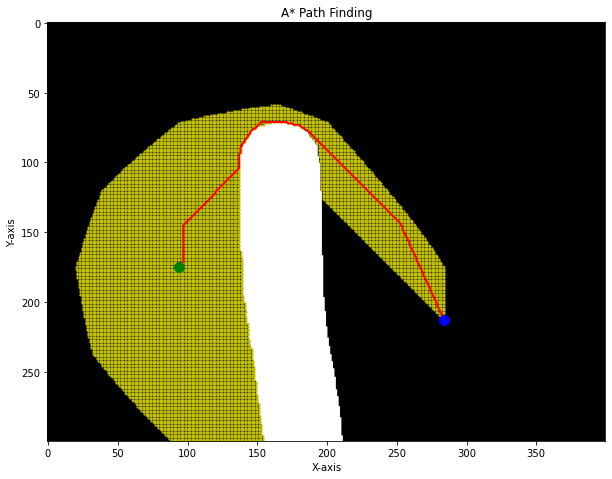

distance to keypoint:  57.658119183800125
len path :  3
distance to keypoint:  305.1112559030142
distance to keypoint:  312.1551073986081
distance to keypoint:  318.67959424341564
distance to keypoint:  320.3651055381136
distance to keypoint:  320.9819148983816
distance to keypoint:  318.3349627670611
distance to keypoint:  313.20864162773324
distance to keypoint:  308.27309905443286
distance to keypoint:  300.2248191811902
distance to keypoint:  291.1247334037147
distance to keypoint:  280.49175828658997
distance to keypoint:  269.1942482149874
distance to keypoint:  260.1909601267211
distance to keypoint:  248.40968162104716
distance to keypoint:  237.76281965885093
distance to keypoint:  225.32791742016568
distance to keypoint:  214.38978786183645
distance to keypoint:  201.61596871737623
distance to keypoint:  189.3963453319343
distance to keypoint:  177.2322395337962
distance to keypoint:  163.35759889446112
distance to keypoint:  150.82287683667053
distance to keypoint:  136.3090

In [4]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import cv2
from tdmclient import ClientAsync, aw
from final_camera_class import *
from final_Thymio_class import *
from final_path import *
from motion import *

###########################################################
#Parameters
###########################################################
camera_index=1 #0 if no webcam
corner_aruco_id=[0, 1, 2, 10] #top-left, bottom-left, bottom-right, top-right
corner_aruco_size=65 #mm
min_size=500 #minimum blob size
thresh_obstacle=np.array([[40,20,120,65,50,160]]) #BGR
thresh_goal=np.array([40,40,20,60,150,65]) #BGR
Thymio_id=9
grid_size0=400 #blocks? TBD numbers of blocks or pixels?
grid_size1=300 #blocks? TBD numbers of blocks or pixels?
ANGLE_THRESHOLD = np.radians(40)   #threshold under which changes of directions are ignored [rad]
STEP = 10                           #step (in number of cells) between each cell we study
COUNTER_THRESHOLD = 10              #max number of steps between keypoints
keypoint_dist_thresh=75 #[mm]

###########################################################
#Main Code
###########################################################
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
aw(node.lock())

async def main():
    
    cv2.destroyAllWindows()
    
    #Camera initialization
    cam=camera_class(camera_index,corner_aruco_id,corner_aruco_size,min_size, thresh_obstacle, thresh_goal)

    #Thymio initialization
    Thymio=Thymio_class(Thymio_id,cam)


    Path_planning=True #We want to have the path
    step = 0
    searching = True
    
    while True :
        step = step + 1
        #Update Image
        cam.get_image()
        cam.correct_perspective_aruco(get_matrix=False)
        #Path Planning
        if Path_planning:
            if Thymio.target_keypoint==None: #only possible at first iteration to not take time later
                do_plot=True
            grid=discretize_image_eff(cam.thresholded_image,grid_size0, grid_size1)
            #Careful! Image frame's first coord (x) is pointing right but in a matrix the first coordinate (rows) is pointing down so they must be inverted
            path, _, _ = a_star_search(grid, grid1_coord2grid2_coord(np.array([Thymio.xytheta_est[1],Thymio.xytheta_est[0]]),cam.persp_image,grid), grid1_coord2grid2_coord(np.array([cam.goal_center[1],cam.goal_center[0]]),cam.persp_image,grid),do_plot)

            # Convert path coordinates for plotting
            path_img = grid1_coord2grid2_coord(path, grid, cam.persp_image)
            path_img = path_img[::-1]
            
            Thymio.keypoints=find_keypoints(path_img,ANGLE_THRESHOLD,STEP,COUNTER_THRESHOLD)
            Thymio.target_keypoint=Thymio.keypoints[0]
            Thymio.keypoints=Thymio.keypoints[1:]
            
            do_plot=False
            Path_planning=False

        #Thymio Position and motor 
        Thymio.Thymio_position_aruco(cam.persp_image)
        Thymio.delta_time_update()
        #TBD await get motor speed something       

        if Thymio.Thymio_detected:
            #TBD Thymio.kalmanfilter_detected don't forget variance of kalman filter in plot!!
            pass
        else:
            #TBD Thymio.kalmanfilter_not_detected
            pass

        #Obstacle detection
        #TBD await get oprox sensor data
        obstacle=False #TBD
        if obstacle:
            Thymio.local_avoidance=True
            #TBD Thymio.local avoidance to update target motor speed
            #TBD await set speed (thymio.speed)
            draw_on_image(cam,Thymio,path_img)
            continue
        else:
            if Thymio.local_avoidance:
                Path_planning=True
                draw_on_image(cam,Thymio,path_img)
                continue
        #Target Achieved?
            else:
                if((step % 5)==0) :
                    #Next keypoint and controller:
                    #print("distance to keypoint: ", distance_to_goal(Thymio.xytheta_meas, Thymio.target_keypoint, cam.pixbymm))
                    if(distance_to_goal(Thymio.xytheta_meas, Thymio.target_keypoint, cam.pixbymm)<keypoint_dist_thresh) :
                        if(len(Thymio.keypoints)<=1): #Thymio found the goal
                            break
                        Thymio.keypoints=Thymio.keypoints[1:]
                        Thymio.target_keypoint=Thymio.keypoints[0]

                    v_m = motion_control(Thymio.xytheta_meas, Thymio.target_keypoint, cam.pixbymm)
                    await node.set_variables(v_m)
                
                draw_on_image(cam,Thymio,path_img)
    cam.cam.release()
    #cv2.destroyAllWindows()

# Run the main asynchronous function
client.run_async_program(main)
print("Mission accomplished")
aw(node.stop())
aw(node.unlock())

In [ ]:
# Stop the program
aw(node.stop())
aw(node.unlock())

In [ ]:
cam.cam.release()

In [1]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
aw(node.lock())

# Stop the program
aw(node.stop())
aw(node.unlock())